# Callbacks in Scikit-Optimize

Todd Young

## Introduction 

Callbacks are functions that, when passed as an argument to another function, are invoked after some event in the parent function completes.

Callbacks in Scikit-Optimize can give you a view into what is happening in your optimization. This can be as simple as making the optimization verbose or timing the the iterations of your optimization procedure. Callbacks can also give you finer control over the optimization procedure through early stopping. For those who need something a bit beyond what the default functions can provide, it is even possible to write custom callbacks.

Let's take a look at Scikit-Optimize's monitoring and early stopping callbacks as well as how to write your own custom callback. Say you are looking at the following Hartmann 3 function [[1]](http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1488.htm) and would like find its global minimum using a Gaussian process.

In [1]:
import numpy as np

def hart3(x,
          alpha=np.asarray([1.0, 1.2, 3.0, 3.2]),
          P=10**-4 * np.asarray([[3689, 1170, 2673],
                                 [4699, 4387, 7470],
                                 [1091, 8732, 5547],
                                 [381, 5743, 8828]]),                   
          A=np.asarray([[3.0, 10, 30],
                       [0.1, 10, 35],
                       [3.0, 10, 30],
                       [0.1, 10, 35]])):
    """
    The 3-dimensional Hartmann function with 4 local minima.
    The function is usually evaluated on the hypercube xi ∈ (0, 1), for all i = 1, 2, 3.
    Global minimum is at f(x*) = -3.86278 at x* = (0.114613, 0.555649, 0.852547)
    See more here: http://www.sfu.ca/~ssurjano/hart3.html
    """
    return -np.sum(alpha * np.exp(-np.sum(A * (np.array(x) - P)**2, axis=1)))

## Verbose Mode

The simplest callback comes in the form of verbose mode. Since it can be a bit worrisome to wait on your function to finish without any feedback, many Python libraries having iterative processes provide a verbose mode, and skopt is no exception. 

In [3]:
from skopt import gp_minimize

dimensions  = [(0.0, 1.0), # Bounds to search for each dimension
               (0.0, 1.0),
               (0.0, 1.0)]           

res = gp_minimize(hart3,                  # the function to minimize
                  dimensions=dimensions,  # the bounds on each dimension of x
                  acq_func="EI",          # the acquisition function
                  n_calls=5,             # the number of evaluations of our function 
                  n_random_starts=5,      # the number of random initialization points
                  random_state=123,       # the random state
                  verbose=True)           # the verbose callback!

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0019
Function value obtained: -0.5198
Current minimum: -0.5198
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0008
Function value obtained: -0.8106
Current minimum: -0.8106
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0008
Function value obtained: -0.2488
Current minimum: -0.8106
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0008
Function value obtained: -1.9504
Current minimum: -1.9504
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0008
Function value obtained: -0.5765
Current minimum: -1.9504


#### Verbose is a Callback

When we set `verbose=True`, we are invoking a callback. Here is what is what is happening under the hood:

To see that this is really happening, let's do something absurd. Let's set `verbose=False`, and then explicitly call the `VerboseCallback` class in our `callback` argument. This gives us the same output as when we set `verbose=True`.

In [4]:
from skopt.callbacks import VerboseCallback

res = gp_minimize(hart3,                  
                  dimensions=dimensions,  
                  acq_func="EI",          
                  n_calls=5,         
                  n_random_starts=5,      
                  random_state=123,       
                  verbose=False,                         # Note this is False! 
                  callback=VerboseCallback(n_total=5))   # explicitly calling the callback!

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.0201
Function value obtained: -0.5198
Current minimum: -0.5198
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.0007
Function value obtained: -0.8106
Current minimum: -0.8106
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.0008
Function value obtained: -0.2488
Current minimum: -0.8106
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.0008
Function value obtained: -1.9504
Current minimum: -1.9504
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 0.0008
Function value obtained

## Timer Callback 

You may have noticed that verbose mode gave the time taken for each iteration to complete. What if we would like to keep that information for later use? Scikit-Optimize has a callback for that, the timer callback. 

In [50]:
from skopt.callbacks import TimerCallback

keep_time = TimerCallback()

res = gp_minimize(hart3,                  
                  dimensions=dimensions,  
                  acq_func="EI",          
                  n_calls=15,         
                  n_random_starts=5,      
                  random_state=123,       
                  verbose=False,         
                  callback=keep_time)   # store our evaluation time

After initializing the `TimerCallback` class, we simply pass it to our optimization procedue with the `callback` argument. This call back then quietly stores of the time spent on each iteration of the optimization in a list of floats.

From there, we could find 

In [51]:
iter_time_min = min(keep_time.iter_time)
iter_time_ave = sum(keep_time.iter_time) / len(keep_time.iter_time)
iter_time_max = max(keep_time.iter_time)
iter_time_total = sum(keep_time.iter_time)

print("Shortest time for an iteration to comlete: {:.4} Seconds".format(iter_time_min))
print("Average time per iteration of our optimization: {:.4} Seconds".format(iter_time_ave))
print("Longest time for an iteration to complete: {:.4} Seconds".format(iter_time_max))
print("Total time for optimization: {:.4} Seconds\n".format(iter_time_total))

func_min = res.fun
print("Function minimum found by optimization: {:.4}".format(func_min))

Shortest time for an iteration to comlete: 0.0002031 Seconds
Average time per iteration of our optimization: 0.2694 Seconds
Longest time for an iteration to complete: 0.4569 Seconds
Total time for optimization: 4.041 Seconds

Function minimum found by optimization: -3.844


## Early Stopping

The early stopping callback gives us finer control over the optimization procedure. Imagine you are running an optimization over some complicated function. How long should you let it run? If the problem is difficult, we will not know how many iterations we should run apriori. 

Let's run the same Gaussian process to find the minimum of the Hartmann 3 function. Just to make sure we give it ample time to search the space, let's let it run for 50 iterations. Let's also keep track of the amount of time the optimization takes. 

In [39]:
from skopt.callbacks import TimerCallback

keep_time = TimerCallback()

res = gp_minimize(hart3,                  
                  dimensions=dimensions,  
                  acq_func="EI",          
                  n_calls=50,         
                  n_random_starts=5,      
                  random_state=123,       
                  verbose=False,         
                  callback=keep_time)   # store our evaluation time

runtime = sum(keep_time.iter_time)
func_min = res.fun

print("Optimization total runtime: {:.4}\n".format(runtime))
print("Minimum found by optimization: {:.4}".format(func_min))s

Minimum found by optimization: -3.863
Optimization total runtime: 22.31



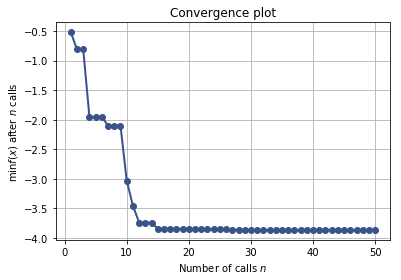

In [10]:
%matplotlib inline
from skopt.plots import plot_convergence

plot_convergence(res)

In [21]:
res_gp = gp_minimize(objective, space, n_calls=10, random_state=0, callback=have_the_time)

In [22]:
len(have_the_time.iter_time)

45

In [25]:
from skopt.callbacks import EarlyStopper, DeltaYStopper

early_stop = DeltaYStopper(delta=0.5)

In [26]:
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0, callback=[talk_to_me, early_stop])

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 978.5730
Function value obtained: 6.3734
Current minimum: 6.3734
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 978.7911
Function value obtained: 5.6234
Current minimum: 5.6234
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 979.0043
Function value obtained: 3.6166
Current minimum: 3.6166
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 979.2358
Function value obtained: 7.0728
Current minimum: 3.6166
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 979.4463
Function value obtained: 5.9574
Current minimum: 3.6166
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 979.9679
Function value obtained: 3.4509
Current minimum: 3.4509
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 980.3369
Function value obtained: 4.1702
Current m

In [28]:
len(res_gp)

8

In [40]:
early_stop_time = TimerCallback()

early_stop_small = DeltaYStopper(delta=0.01)
res = gp_minimize(objective, space, n_calls=100, random_state=0, callback=[early_stop_time, early_stop_small])

In [44]:
len(early_stop_time.iter_time)

26

In [45]:
earlystop_largedelta = TimerCallback()

early_stop_small = DeltaYStopper(delta=0.5)
res = gp_minimize(objective, space, n_calls=100, random_state=0, callback=[earlystop_largedelta, early_stop_small])

In [48]:
len(earlystop_largedelta.iter_time)

15

## References 

[1] http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page1488.htm